In [92]:
%%capture
#This is to fix the datasets.load_dataset compatibility with latest fsspec
!pip install fsspec==2023.9.2

#Imports





In [165]:
# %%capture
import pandas as pd
import numpy as np
import datasets
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Ingest Data

In [3]:
def ingest_data():
  ds = datasets.load_dataset("google-research-datasets/go_emotions")
  return ds

In [177]:
ds = ingest_data()

# EDA

In [13]:
# Number of examples in each split
splits = ["test","train","validation"]
for split in splits:
  print(f"{split} : " +str(ds[split].num_rows))

test : 5427
train : 43410
validation : 5426


In [24]:
# Available keys in features split
ds['test'].features.keys()

dict_keys(['text', 'labels', 'id'])

In [70]:
# Exploring data entries
print(ds['test'].to_pandas().head())
print(ds['test'].to_pandas().tail())

                                                text labels       id
0  I’m really sorry about your situation :( Altho...   [25]  eecwqtt
1    It's wonderful because it's awful. At not with.    [0]  ed5f85d
2  Kings fan here, good luck to you guys! Will be...   [13]  een27c3
3  I didn't know that, thank you for teaching me ...   [15]  eelgwd1
4  They got bored from haunting earth for thousan...   [27]  eem5uti
                                                   text labels       id
5422  Thanks. I was diagnosed with BP 1 after the ho...   [15]  efeeasc
5423                             Well that makes sense.    [4]  ef9c7s3
5424                                Daddy issues [NAME]   [27]  efbiugo
5425  So glad I discovered that subreddit a couple m...    [0]  efbvgp9
5426  Had to watch "Elmo in Grouchland" one time too...   [27]  edtjpv6


In [83]:
# All available labels and corresponding integer
label_list = ds['test'].features['labels'].feature.names
label_dict = {x:y for x,y in enumerate(label_list)}
label_dict

{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'caring',
 6: 'confusion',
 7: 'curiosity',
 8: 'desire',
 9: 'disappointment',
 10: 'disapproval',
 11: 'disgust',
 12: 'embarrassment',
 13: 'excitement',
 14: 'fear',
 15: 'gratitude',
 16: 'grief',
 17: 'joy',
 18: 'love',
 19: 'nervousness',
 20: 'optimism',
 21: 'pride',
 22: 'realization',
 23: 'relief',
 24: 'remorse',
 25: 'sadness',
 26: 'surprise',
 27: 'neutral'}

In [112]:
# 5 examples from every emotion , class distribution
class_dist = {}
for i in range(28):
  example_text = [x for x in ds['test'] if i in x['labels']]
  class_dist[i] = len(example_text)
  print("Emotion : " + label_dict[i])
  for j in example_text[:5]:
    print(j['text'])

Emotion : admiration
It's wonderful because it's awful. At not with.
It's great that you're a recovering addict, that's cool. Have you ever tried DMT?
This guy is a little turd but I love him so dearly. I'll pass on your kisses :)
in what universe? lol the mr. blue sky cover is one of the best on the album imo.
Lol looks delicious
Emotion : amusement
Lol! But I love your last name though. XD
Triggered:: Welp guess it's time for me to re-up lol
I know you're joking, but there are people here either stupid or desperate enough to believe and perpetuate such idiocy. 
in what universe? lol the mr. blue sky cover is one of the best on the album imo.
You sure? They seem so much brighter on screen lol
Emotion : anger
Eff your video - love Canada 🇨🇦 Stupid geolock
That's too many pills
Talk about an oldddd school shit coin.
How dare you! Don’t you know seatbelts cause autism!
Damnit Morty! D'you see wha-rrrgh-t you've done!? We're fucked Morty, the squirrels - they're recruiting dolphins now Mo

In [114]:
# Distribution of classes
class_dist

{0: 504,
 1: 264,
 2: 198,
 3: 320,
 4: 351,
 5: 135,
 6: 153,
 7: 284,
 8: 83,
 9: 151,
 10: 267,
 11: 123,
 12: 37,
 13: 103,
 14: 78,
 15: 352,
 16: 6,
 17: 161,
 18: 238,
 19: 23,
 20: 186,
 21: 16,
 22: 145,
 23: 11,
 24: 56,
 25: 156,
 26: 141,
 27: 1787}

Max length = 184
Average length = 67.82476506357104


(array([597., 933., 857., 906., 769., 641., 432., 238.,  42.,  12.]),
 array([  5. ,  22.9,  40.8,  58.7,  76.6,  94.5, 112.4, 130.3, 148.2,
        166.1, 184. ]),
 <BarContainer object of 10 artists>)

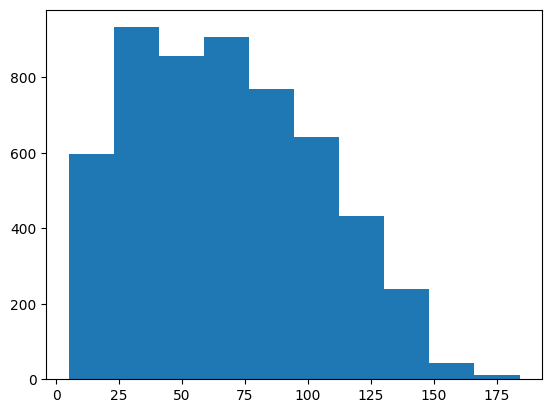

In [110]:
# Max , avg len of all
lenArray = []
maxLen = 0
avgLen = 0
for x in ds["test"]:
  lengthOfText = len(x['text'])
  maxLen = max(maxLen,lengthOfText)
  avgLen += lengthOfText
  lenArray.append(lengthOfText)
print(f"Max length = {maxLen}")
print(f"Average length = {avgLen/ds['test'].num_rows}")
plt.hist(lenArray)


In [167]:
model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [181]:
# Preprocessing our data and making it training ready
def preprocessing_data(ds):
  # Train ds pipeline
  ds['train'] = ds['train'].map(lambda x:{'text':tokenizer(x['text'],padding = "max_length",truncation = True,max_length = 180,return_tensors = 'tf'),'labels':x['labels'],'id':x['id']})
preprocessing_data(ds)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


ValueError: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).

In [179]:
ds['train'][0]

{'text': {'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'input_ids': [101,
   2026,
   8837,
   2833,
   2003,
   2505,
   1045,
   2134,
   1005,
   1056,
   2031,
   2000,
   5660,
   2870,
   1012,
   102]},
 'labels': [27],
 'id': 'eebbqej'}